In [ ]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [1]:
# Import libraries
from time import time
from joblib import Memory
from scipy import sparse
from scipy import linalg
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import nibabel as nib
import tempfile
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import FeatureAgglomeration
from sklearn.cluster import ward_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
import SimpleITK as sitk
import six
from radiomics import featureextractor 
from radiomics import imageoperations
import numpy as np
from numpy import linalg
import os
import pywt

%matplotlib widget

In [2]:
# Load data
segs = []
qsms = []
voxel_sizes = []
directory = 'F:\dbs\outcome_predictor\snrn_cases'
for filename in os.listdir(directory):
    f = os.path.join(directory,filename)
    print(f)
    # Set aside test case
    if '47' not in filename:
        try:
            seg = nib.load(f+'/seg.nii')
        except:
            seg = nib.load(f+'/seg.nii.gz')
    
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata())
        try:
            qsm = nib.load(f+'/qsm.nii')
        except:
            qsm = nib.load(f+'/qsm.nii.gz')
        qsms.append(qsm.get_fdata())
    # Training cases
    else:
        try:
            seg_t = nib.load(f+'/seg.nii')
        except:
            seg_t = nib.load(f+'/seg.nii.gz')
        voxel_size_t = seg_t.header['pixdim'][0:3]
        try:
            qsm_t = nib.load(f+'/qsm.nii')
        except:
            qsm_t = nib.load(f+'/qsm.nii.gz')

n_cases = len(segs)
        

F:\dbs\outcome_predictor\snrn_cases\074
F:\dbs\outcome_predictor\snrn_cases\056
F:\dbs\outcome_predictor\snrn_cases\070
F:\dbs\outcome_predictor\snrn_cases\073
F:\dbs\outcome_predictor\snrn_cases\047
F:\dbs\outcome_predictor\snrn_cases\034
F:\dbs\outcome_predictor\snrn_cases\044
F:\dbs\outcome_predictor\snrn_cases\046
F:\dbs\outcome_predictor\snrn_cases\040
F:\dbs\outcome_predictor\snrn_cases\029
F:\dbs\outcome_predictor\snrn_cases\032
F:\dbs\outcome_predictor\snrn_cases\039


In [3]:
# Generate feature structure Phi from all ROIs and all cases
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()
#extractor.enableAllImageTypes()
Phi = []
seg_t_sitk = sitk.GetImageFromArray(seg_t.get_fdata())
seg_t_sitk.SetSpacing(voxel_size_t.tolist())
qsm_t_sitk = sitk.GetImageFromArray(qsm_t.get_fdata())
qsm_t_sitk.SetSpacing(voxel_size_t.tolist())
# Create separate feature vector for test case
for j in range(1,int(np.max(segs[0]))+1):
    featureVector_t = extractor.execute(qsm_t_sitk,seg_t_sitk,label=j)

# Training cases
for i in range(n_cases):
    seg_sitk = sitk.GetImageFromArray(segs[i])
    seg_sitk.SetSpacing(voxel_sizes[i].tolist())
    qsm_sitk = sitk.GetImageFromArray(qsms[i])
    qsm_sitk.SetSpacing(voxel_sizes[i].tolist())
    for j in range(1,int(np.max(segs[i]))+1):
        featureVector = extractor.execute(qsm_sitk,seg_sitk,label=j)
        Phi.append(featureVector)


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

In [4]:
# Extract numeric feature values
x_row = []
loop_count = 0
for i in range(n_cases):
    for j in range(int(np.max(segs[i]))):
        featureVector = Phi[j]
        loop_count = loop_count+1
        for key, value in six.iteritems(featureVector):
            if 'diagnostic' in key:
                next
            else:
                x_row.append(value)
X0 = np.array(x_row)

# Test case
x_row_t = []
for j in range(int(np.max(segs[0]))):
        featureVector = featureVector_t
        loop_count = loop_count+1
        for key, value in six.iteritems(featureVector):
            if 'diagnostic' in key:
                next
            else:
                x_row_t.append(value)
X0_t = np.array(x_row_t)

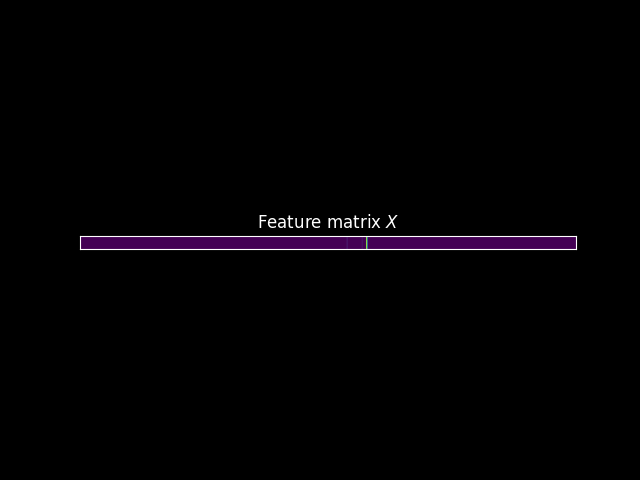

In [6]:
# Visualize feature matrix X
X = X0.reshape((n_cases,int(len(X0)/n_cases)))
fig,ax = plt.subplots(1,1)
plt.style.use('dark_background')
plt.imshow(X)
plt.xticks([])
plt.yticks([])
plt.title('Feature matrix $X$');
# Normalize testing and training cases together
#   Otherwise the scale during clf.predict() is wrong
scaler = StandardScaler()
# What are the default parameters for this scaling?
X_all = np.vstack((X,X0_t))
X_all_t = scaler.fit_transform(X_all)
X_t = X_all_t[X.shape[0]:,:]
X = X_all_t[:X.shape[0]]

In [7]:
# UPDRS targets
#   Must be ordered according to list-generating loop
#   Larger data arrays will need a text file in each directory
#   So targets and inputs can be read simultaneously

u = np.array([0,2,6,4],
[3,3,0,2],
[3,9,15,2],
[7,5,17,2],
[2,13,30,6],
[3,8,32,4],
[3,10,24,2],
[1,3,18,2],
[2,10,26,8],
[3,3,25,0],
[0,0,13,0],
[0,10,33,4]])



In [ ]:
# Cross-validation for model selection
cv = KFold(3)
cachedir = tempfile.mkdtemp()
mem = Memory(location=cachedir, verbose=1)
# Lasso loss function
#   If fit_intercept=False, predictions are negative...odd
#   None of the training data is negative, does this indicate a problem?
#   Set upper and lower limits based on UPDRS?
alphas = ((1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3))
lasso = Lasso(alpha=0.1,fit_intercept=False,max_iter=10000,tol=0.0001)
ward = FeatureAgglomeration(n_clusters=100, linkage="ward",memory=mem)

clf = Pipeline([("ward", ward), ("Lasso", lasso)])
# # Select the optimal number of clusters with grid search
clf = GridSearchCV(clf, {"Lasso__alpha" : alphas, "ward__n_clusters": [5,10,25,100,1000]}, n_jobs=1, cv=cv, scoring='r2')
clf.fit(X,u)  

In [ ]:
# Plot clustered feature matrix
ward = FeatureAgglomeration(n_clusters=clf.best_estimator_['ward'].n_clusters, linkage="ward",memory=mem)
Xw = ward.fit_transform(X,u)
print('Ward clustering found '+str(Xw.shape[1])+ ' distinctive features')
fig,ax = plt.subplots(1,1)
plt.style.use('dark_background')
plt.imshow(Xw)
plt.xticks([])
plt.yticks([])
plt.title('Feature matrix $X$');

In [ ]:
clf.best_estimator_.get_params()

In [ ]:
# Set best parameters from cross-validation
# Ward-Lasso w* of length reduced number of features in Xw
coef_lasso = clf.best_estimator_.steps[-1][1].coef_
# Lasso w* of length of original number of features in X
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_lasso)
# Summary feature dimensionality reduction and selection
print("From original " +str(X.shape[1])+" features,"+" Ward clustering and LASSO cross-validation found " + str(np.count_nonzero(coef_)) + " features that should have nonzero weights")
# Predict test case
clf.best_estimator_.predict(X_t)

In [ ]:
lasso_c = Lasso(alpha=0.1,fit_intercept=False,max_iter=10000,tol=0.0001)

In [ ]:
# Test impact of Ward feature dimensionality reduction and cross-validation
# Makes sense that there is no impact on overall estimator because
# Dataset is not homogenously PD patients so cross-validation assumption of iid data fails
ovr = OneVsRestClassifier(clf.best_estimator_)
ovr_c = OneVsRestClassifier(lasso_c)


In [ ]:
# fit model
ut = []
for k in range(u.shape[1]):
    ovr.fit(X,u[:,k])
    # make predictions
    ut.append(ovr.predict(X_t))

In [ ]:
ut0 = (2,13,30,6)


In [ ]:
ut